In [1]:
from typing import List, Dict, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import klib as kl
import missingno as mns
import os
import warnings
import pickle

from econml.iv.dr import LinearIntentToTreatDRIV

os.environ['KERAS_BACKEND']='tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['Kaiti']
plt.rcParams['axes.unicode_minus'] = False
PIC_PATH = "../models/image/image3"
DATA_PATH = '../data/data/'
RESULT_PATH = '../data/summary/'
MODEL_PATH = '../models/model3/'

np.random.seed(42)

G:\Language\Anaconda\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
G:\Language\Anaconda\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_pa

In [2]:
import pathlib2 as pl2
import shutil

def creat_dir():
    pic_path = pl2.Path(PIC_PATH)
    if os.path.exists(PIC_PATH):
        shutil.rmtree(PIC_PATH)
    pic_path.mkdir(parents=True, exist_ok=True)
    if not os.path.exists(RESULT_PATH):
        os.mkdir(RESULT_PATH)
    if not os.path.exists(MODEL_PATH):
        os.mkdir(MODEL_PATH)

creat_dir()

In [3]:
figure_count = 0

def create_figure(figure_name, dpi=800):
    global figure_count
    figure_count += 1
    plt.savefig(PIC_PATH + f'/figure{figure_count}_{figure_name}.png', dpi=dpi)

In [4]:
data = pd.read_excel(DATA_PATH + '附件10.xls', index_col=0)
data

,库深/m,库容,断层类型,构造活动/基本烈度,岩性,震级
样本,,,,,,
1,53.0,0.04,正断,1.0,沉积岩,1.0
2,68.0,1.70,正断,1.0,变质岩,1.0
3,106.0,3.40,正断,1.0,变质岩,1.0
4,85.0,4.00,正断,1.0,沉积岩,1.0
5,136.0,4.60,正断,1.0,变质岩,1.0
...,...,...,...,...,...,...
98,122.0,177.50,走滑,7.7,沉积岩,5.9
99,97.0,115.00,逆断,8.0,岩浆岩,6.1
100,122.0,1750.00,逆断,8.0,岩浆岩,6.1


In [5]:
data['断层类型'].unique()

array(['正断', '走滑', '逆断'], dtype=object)

In [6]:
data['岩性'].unique()

array(['沉积岩', '变质岩', '岩浆岩', '岩浆层'], dtype=object)

In [7]:
data['岩性'] = data['岩性'].str.replace('层', '岩')
data['岩性'].unique()

array(['沉积岩', '变质岩', '岩浆岩'], dtype=object)

In [8]:
dummies = pd.get_dummies(data, columns=['断层类型', '岩性'])
dummies

,库深/m,库容,构造活动/基本烈度,震级,断层类型_正断,断层类型_走滑,断层类型_逆断,岩性_变质岩,岩性_岩浆岩,岩性_沉积岩
样本,,,,,,,,,,
1,53.0,0.04,1.0,1.0,1,0,0,0,0,1
2,68.0,1.70,1.0,1.0,1,0,0,1,0,0
3,106.0,3.40,1.0,1.0,1,0,0,1,0,0
4,85.0,4.00,1.0,1.0,1,0,0,0,0,1
5,136.0,4.60,1.0,1.0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
98,122.0,177.50,7.7,5.9,0,1,0,0,0,1
99,97.0,115.00,8.0,6.1,0,0,1,0,1,0
100,122.0,1750.00,8.0,6.1,0,0,1,0,1,0


<AxesSubplot:>

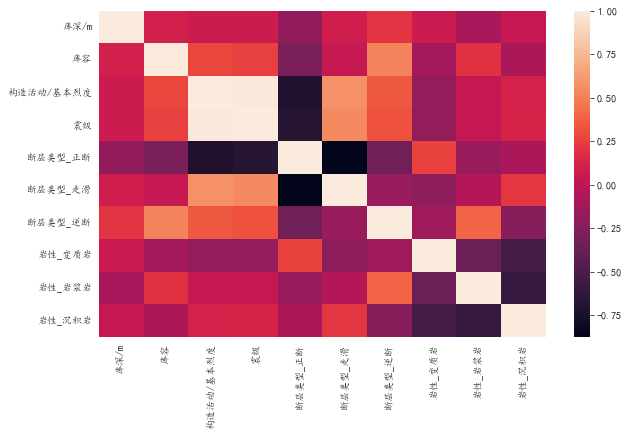

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(dummies.corr())

<AxesSubplot:title={'center':'Feature-correlation (pearson)'}>

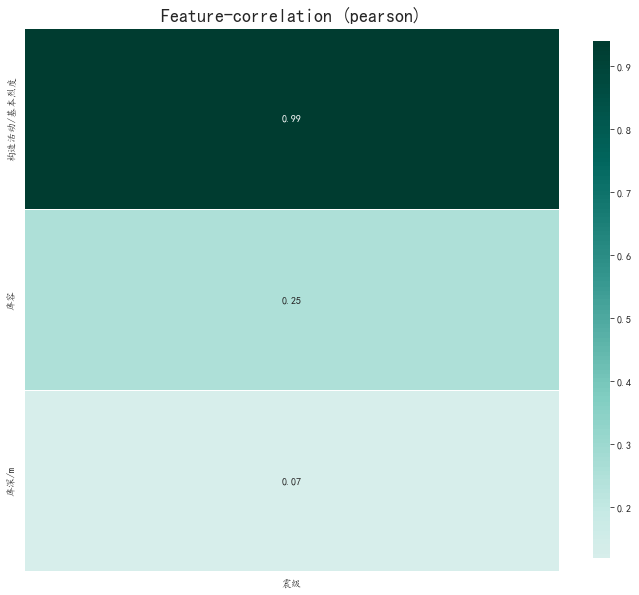

In [10]:
kl.corr_plot(data, target='震级')

In [11]:
group_rock = data.groupby('岩性')
for rock in data['岩性'].unique():
    group_rock.get_group(rock).describe().to_csv(RESULT_PATH + rock + '.csv')

In [12]:
group_type = data.groupby('断层类型')
for typing in data['断层类型'].unique():
    group_type.get_group(typing).describe().to_csv(RESULT_PATH + typing + '.csv')

In [35]:
from sklearn.preprocessing import LabelEncoder

l1 = LabelEncoder().fit(data['岩性'])
l2 = LabelEncoder().fit(data['断层类型'])

Y = data['震级']
T = l1.transform(data['岩性']).astype('float32')
X = l2.transform(data['断层类型']).reshape(-1, 1).astype('float32')
W = data[['库深/m', '库容']]

from sklearn.ensemble import GradientBoostingRegressor
from econml.dml import CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

# log_t = np.log(np.abs(T) + 1)

intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=3, min_impurity_decrease=0.001)
est = CausalForestDML(
    model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor()
)
est.fit(Y, T, X=X, W=W, inference="blb", cache_values=True)
intrp.interpret(est, X)

In [36]:
est.summary()

Population summary of CATE predictions on Training Data
Doubly Robust ATE on Training Data Results:  Doubly Robust ATE calculation on training data is available only on discrete treatments!
Doubly Robust ATT on Training Data Results:  Doubly Robust ATT calculation on training data is available only on discrete treatments!


<class 'econml.utilities.Summary'>
"""
               Uncertainty of Mean Point Estimate              
===============================================================
mean_point stderr_mean zstat pvalue ci_mean_lower ci_mean_upper
---------------------------------------------------------------
     0.066       0.163 0.405  0.686        -0.253         0.385
      Distribution of Point Estimate     
=========================================
std_point pct_point_lower pct_point_upper
-----------------------------------------
    0.155          -0.143            0.18
     Total Variance of Point Estimate     
==========================================
stderr_point ci_point_lower ci_point_upper
------------------------------------------
       0.224         -0.503          0.361
------------------------------------------

Note: The stderr_mean is a conservative upper bound.
"""

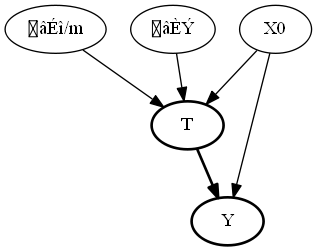

In [14]:
from sklearn.tree import DecisionTreeRegressor
from econml.dml import LinearDML
from IPython.core.display import Image
from networkx.drawing.nx_pydot import to_pydot

est = LinearDML(model_y=DecisionTreeRegressor(), model_t=DecisionTreeRegressor())
est_dw = est.dowhy.fit(Y, T, X=X, Z=W, inference='statsmodels', outcome_names=['Y'], treatment_names=['T'], )
Image(to_pydot(est_dw._graph._graph).create_png())

In [15]:
print(est_dw.identified_estimand_)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d           
────(E[Y|X0])
d[T]         
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,X0,U) = P(Y|T,X0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                 -1⎤
 ⎢     d         ⎛     d          ⎞  ⎥
E⎢───────────(Y)⋅⎜───────────([T])⎟  ⎥
 ⎣d[库容  库深/m]    ⎝d[库容  库深/m]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{库容,库深/m})
Estimand assumption 2, Exclusion: If we remove {库容,库深/m}→{T}, then ¬({库容,库深/m}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



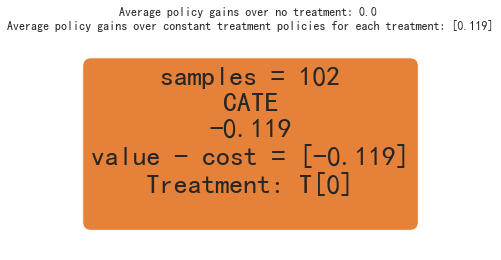

In [16]:
intrp.plot()

In [17]:
from causalml.inference.meta import XGBTRegressor, MLPTRegressor, LRSRegressor

for model in [XGBTRegressor(), MLPTRegressor(), LRSRegressor()]:
    te, lb, ub = model.estimate_ate(X, T, Y)
    print(str(model.__class__))
    print('{:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))
    print(te, lb, ub)

<class 'causalml.inference.meta.tlearner.XGBTRegressor'>
-0.25 (-0.83, 0.32)
[-0.25184442  0.09594282] [-0.8270199  -0.42403513] [0.32333106 0.61592076]
<class 'causalml.inference.meta.tlearner.MLPTRegressor'>
-0.71 (-1.31, -0.11)
[-0.70973563  0.0007794 ] [-1.31281291 -0.5249356 ] [-0.10665835  0.52649441]
<class 'causalml.inference.meta.slearner.LRSRegressor'>
-0.26 (-0.85, 0.32)
[-0.2642531   0.12929591] [-0.84748639 -0.42425864] [0.31898019 0.68285047]


In [18]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metrics(y_true, y_pred):
    return [
        mean_absolute_error(y_true, y_pred),
        mean_absolute_error(y_true, y_pred),
        r2_score(y_true, y_pred)
    ]

In [19]:
from sklearn.model_selection import train_test_split

data['岩性'] = l1.transform(data['岩性'])
data['断层类型'] = l2.transform(data['断层类型'])
X_train, X_test, y_train, y_test = train_test_split(data.drop('震级', axis=1), data.震级, test_size=.3)

In [20]:
for model in [LinearRegression(), BayesianRidge(), KNeighborsRegressor(), SVR(),
              DecisionTreeRegressor(random_state=42), GradientBoostingRegressor(random_state=42),
              RandomForestRegressor(random_state=42)]:
    print(model.__class__.__name__)
    %timeit model.fit(X_train, y_train)
    print(metrics(y_test, model.predict(X_test)))

LinearRegression
940 µs ± 42.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[0.15917492566656002, 0.15917492566656002, 0.9597534719964675]
BayesianRidge
1.18 ms ± 54.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[0.15819853054297803, 0.15819853054297803, 0.9595628464758335]
KNeighborsRegressor
851 µs ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[1.132258064516129, 1.132258064516129, 0.08923671689135626]
SVR
1.08 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[1.1062372276194432, 1.1062372276194432, 0.10919177613734665]
DecisionTreeRegressor
1.11 ms ± 43.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
[0.016129032258064543, 0.016129032258064543, 0.9988049607894969]
GradientBoostingRegressor
17.3 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
[0.025513604082200804, 0.025513604082200804, 0.9977377289587406]
RandomForestRegressor
76.7 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 l

In [21]:
lr = LinearRegression().fit(X_train, y_train)
bayes = BayesianRidge().fit(X_train, y_train)
dt = DecisionTreeRegressor().fit(X_train, y_train)
gbdt = GradientBoostingRegressor().fit(X_train, y_train)
rf = RandomForestRegressor().fit(X_train, y_train)

In [22]:
bayes.coef_, bayes.intercept_, bayes.alpha_, bayes.lambda_, bayes.sigma_

(array([ 2.55483379e-04, -8.53613782e-05, -1.09500253e-01,  6.63373017e-01,
        -3.51991744e-02]),
 1.0639431618567197,
 27.96185212878013,
 10.923751527149477,
 array([[ 1.73817315e-07,  1.38508158e-09, -8.42581531e-06,
          1.24298518e-06,  1.23818603e-06],
        [ 1.38508158e-09,  8.30754926e-09, -1.59734505e-06,
          7.40440894e-08,  3.84742384e-08],
        [-8.42581531e-06, -1.59734505e-06,  3.33384579e-03,
         -5.98187550e-04, -7.13000617e-05],
        [ 1.24298518e-06,  7.40440894e-08, -5.98187550e-04,
          2.35967358e-04, -5.70442656e-05],
        [ 1.23818603e-06,  3.84742384e-08, -7.13000617e-05,
         -5.70442656e-05,  8.53293995e-04]]))

In [23]:
lr.coef_, lr.intercept_

(array([ 2.74912773e-04, -8.27766877e-05, -1.18125439e-01,  6.65883663e-01,
        -3.58563270e-02]),
 1.0561609478309824)

In [24]:
dt.feature_importances_

array([3.14537999e-03, 8.77354120e-04, 3.92845128e-05, 9.95689179e-01,
       2.48801915e-04])

In [25]:
rf.feature_importances_

array([2.34237920e-03, 4.11097809e-03, 1.12452245e-03, 9.91564779e-01,
       8.57341317e-04])

In [26]:
gbdt.feature_importances_

array([1.01350255e-03, 1.68102565e-03, 5.11834128e-04, 9.96691134e-01,
       1.02503737e-04])

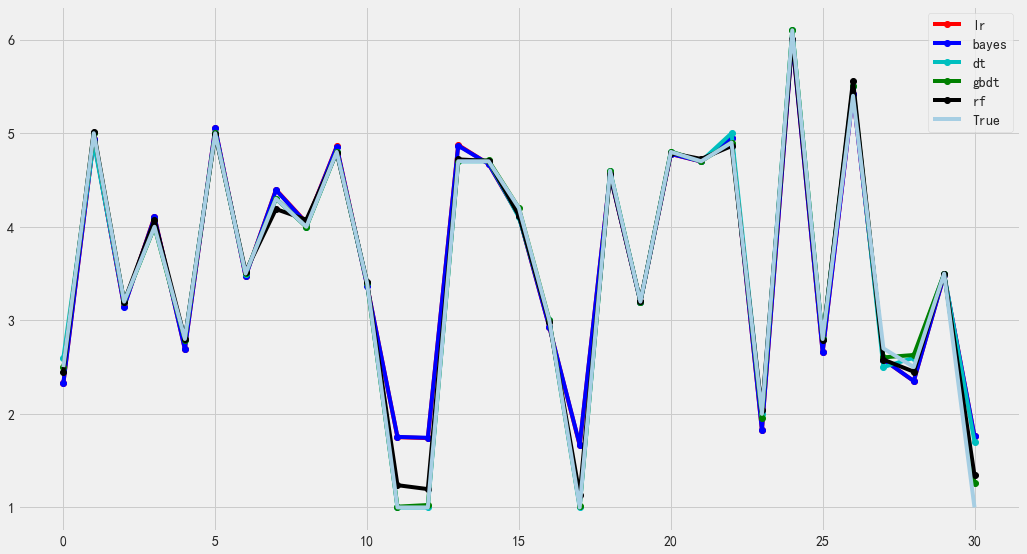

In [37]:
plt.figure(figsize=(16, 9))
plt.plot(lr.predict(X_test), 'ro-', label='lr')
plt.plot(bayes.predict(X_test), 'bo-', label='bayes')
plt.plot(dt.predict(X_test), 'co-', label='dt')
plt.plot(gbdt.predict(X_test), 'go-', label='gbdt')
plt.plot(rf.predict(X_test), 'ko-', label='rf')
plt.plot(y_test.to_list(), label='True')
plt.legend()
create_figure('result')

In [28]:
import shap

explain = shap.TreeExplainer(gbdt)
shap_value = explain.shap_values(X_train)

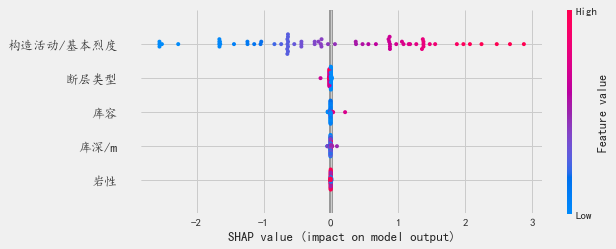

In [29]:
shap.summary_plot(shap_value, X_train)

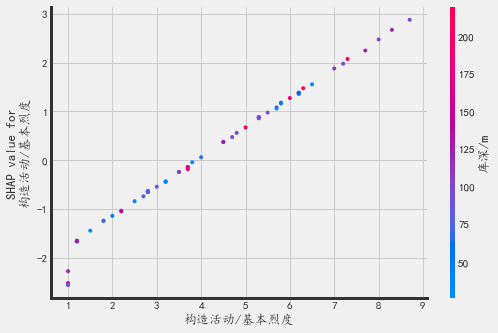

In [30]:
shap.dependence_plot('构造活动/基本烈度', shap_value, X_train)